<a href="https://colab.research.google.com/github/Sam-krish2411/DATA-SCIENCE-ASSIGNMENT/blob/main/TIME_SERIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Part 1: Data Preparation and Exploration**

In [2]:
import pandas as pd

In [3]:
# Load dataset
df = pd.read_csv("exchange_rate.csv")

In [4]:
# Convert Date column to datetime format

df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

In [5]:
# Set Date as index

df.set_index('date', inplace=True)

In [6]:
# Inspect first few rows

print(df.head())
print(df.info())

            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None


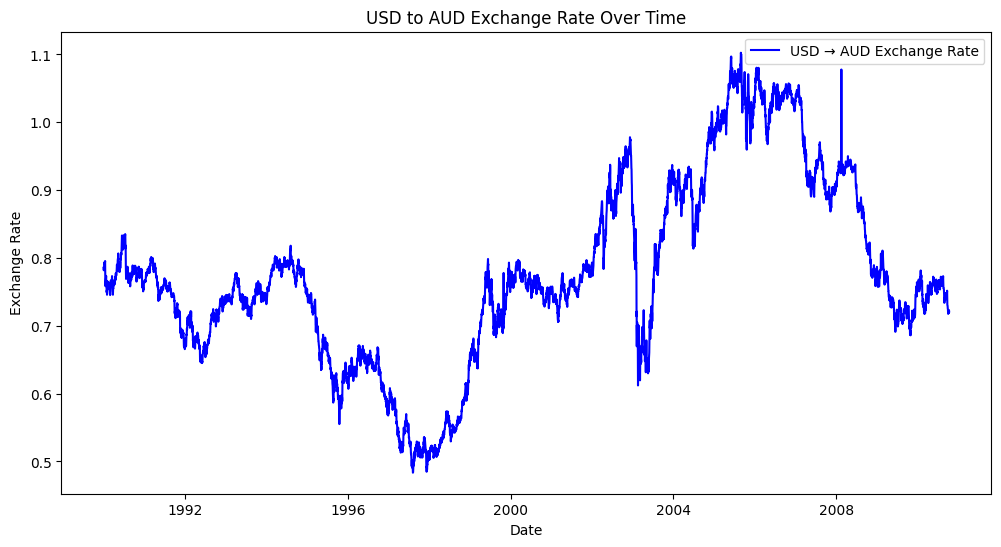

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label="USD → AUD Exchange Rate", color='blue')
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

### 📈 USD to AUD Exchange Rate Over Time — Interpretation

This time series graph illustrates the historical exchange rate between the US Dollar (USD) and the Australian Dollar (AUD) from **1990 to 2009**.

####  Key Observations

- **Fluctuating Trend**: The exchange rate shows multiple peaks and troughs, reflecting periods of USD strength and weakness relative to the AUD.
- **Peak Period (2001–2002)**:
  - The exchange rate exceeds **1.0**, indicating that **1 USD was worth more than 1 AUD**.
  - This suggests a period of strong USD performance, possibly influenced by global economic conditions or interest rate differentials.
- **Post-2004 Decline**:
  - A steady downward trend indicates **AUD appreciation** or **USD weakening**.
  - Could be tied to commodity price shifts, trade balances, or monetary policy changes in either country.

#### Economic Implications

- **Trade Impact**: A stronger USD makes Australian exports cheaper for US buyers, while a stronger AUD can reduce export competitiveness.
- **Investment Decisions**: Currency trends influence foreign investment, hedging strategies, and portfolio diversification.
- **Policy Sensitivity**: Exchange rates are sensitive to central bank actions, inflation, and geopolitical events.



In [8]:
# Summary statistics

print(df['Ex_rate'].describe())

count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64


In [9]:
# Check for missing values

print("Missing values:\n", df.isnull().sum())

Missing values:
 Ex_rate    0
dtype: int64


In [10]:
# Detect and handle anomalies using IQR

q1 = df['Ex_rate'].quantile(0.25)
q3 = df['Ex_rate'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [11]:
# Replace outliers with NaN and forward fill

df['Ex_rate'] = df['Ex_rate'].mask((df['Ex_rate'] < lower_bound) | (df['Ex_rate'] > upper_bound))
df['Ex_rate'] = df['Ex_rate'].fillna(method='ffill')

/tmp/ipython-input-2150497612.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Ex_rate'] = df['Ex_rate'].fillna(method='ffill')


##**Part 2: Model Building - ARIMA**

In [12]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [13]:
# Stationarity check (ADF test)

result = adfuller(df['Ex_rate'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


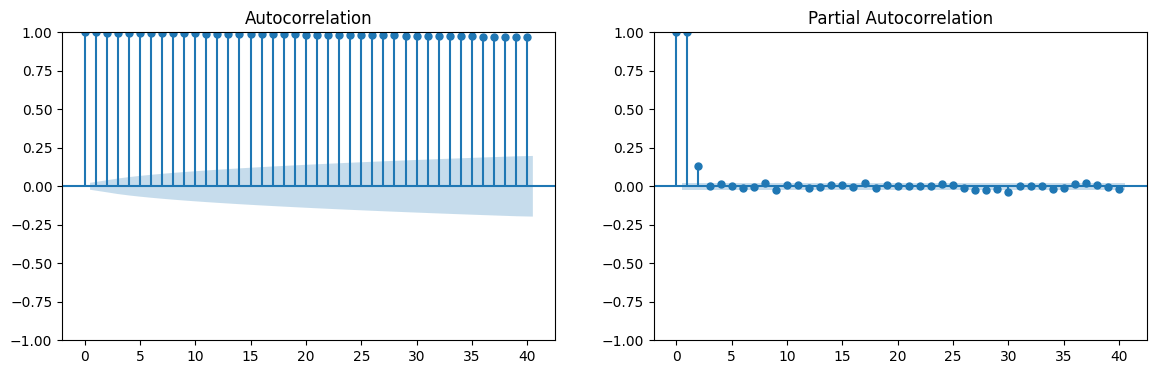

In [14]:
# Plot ACF and PACF

fig, ax = plt.subplots(1,2, figsize=(14,4))
sm.graphics.tsa.plot_acf(df['Ex_rate'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Ex_rate'], lags=40, ax=ax[1])
plt.show()

In [15]:
# First differencing
diff_series = df['Ex_rate'].diff().dropna()


In [16]:
# Re-run ADF test
result_diff = adfuller(diff_series)
print("ADF Statistic (1st Difference):", result_diff[0])
print("p-value:", result_diff[1])

ADF Statistic (1st Difference): -99.39343120118632
p-value: 0.0


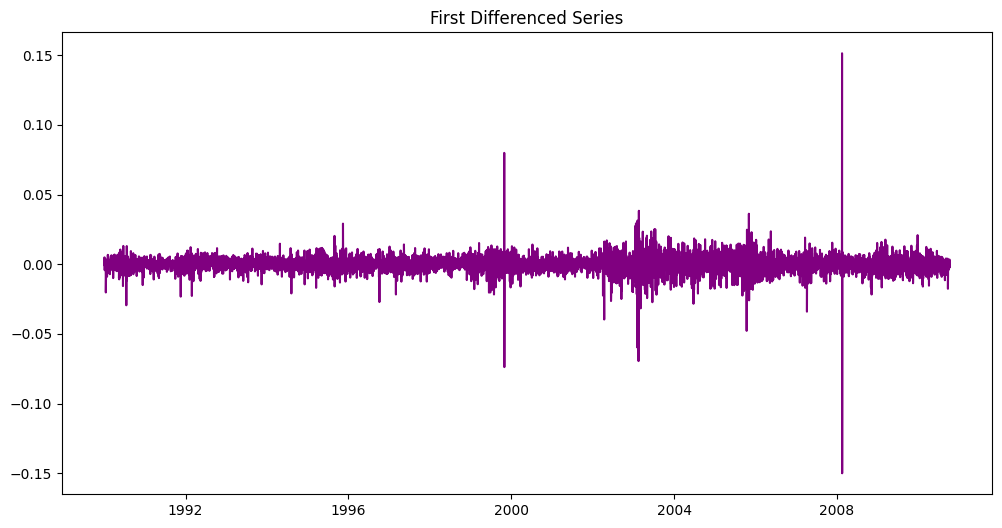

In [17]:
# Plot differenced series

plt.figure(figsize=(12,6))
plt.plot(diff_series, color='purple')
plt.title("First Differenced Series")
plt.show()

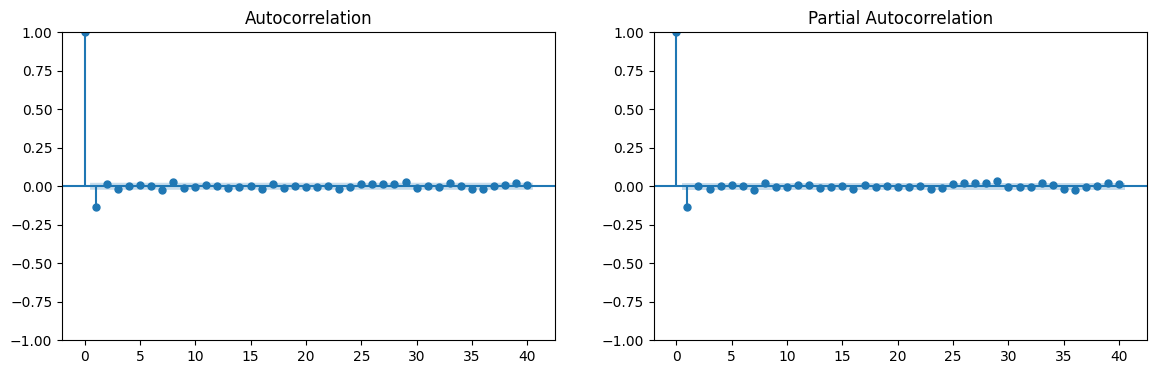

In [18]:
# ACF & PACF of differenced series
fig, ax = plt.subplots(1,2, figsize=(14,4))
sm.graphics.tsa.plot_acf(diff_series, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_series, lags=40, ax=ax[1])
plt.show()

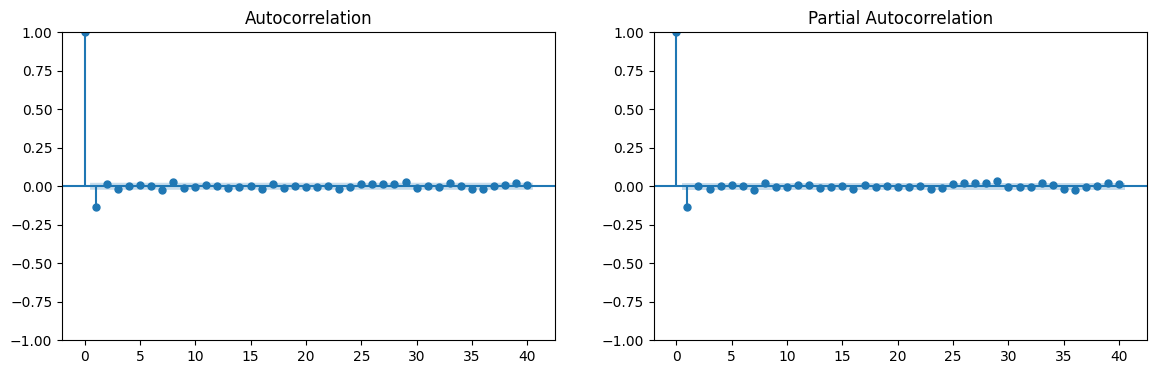

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sm.graphics.tsa.plot_acf(diff_series, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_series, lags=40, ax=ax[1])
plt.show()

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Train-test split (last 20% as test set)
train_size = int(len(df) * 0.8)
train, test = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

# Fit ARIMA model with (p,d,q) = (1,1,1)
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Model summary
print(arima_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Mon, 22 Sep 2025   AIC                         -45432.092
Time:                        08:08:59   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

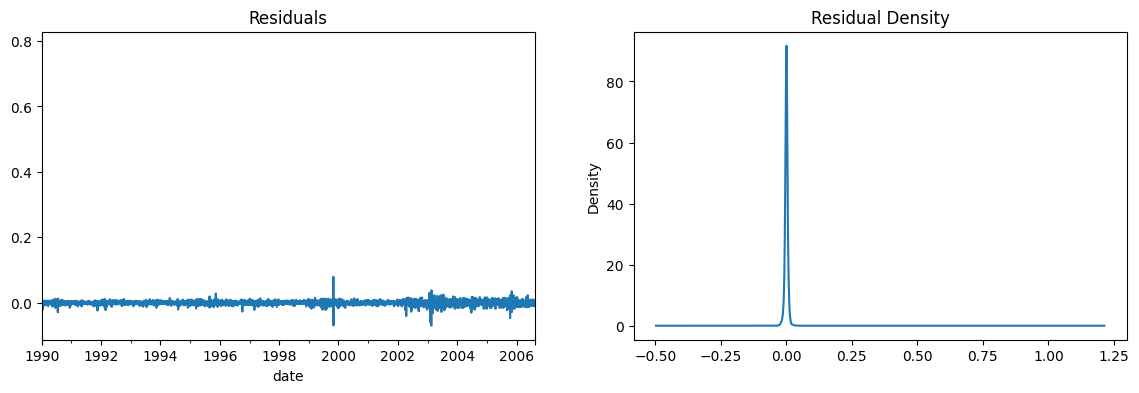

     lb_stat  lb_pvalue
10  1.647217   0.998399


In [21]:
# Residual diagnostics
residuals = arima_fit.resid

# Plot residuals
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(14,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Residual Density', ax=ax[1])
plt.show()

# Ljung-Box test for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(residuals, lags=[10], return_df=True))

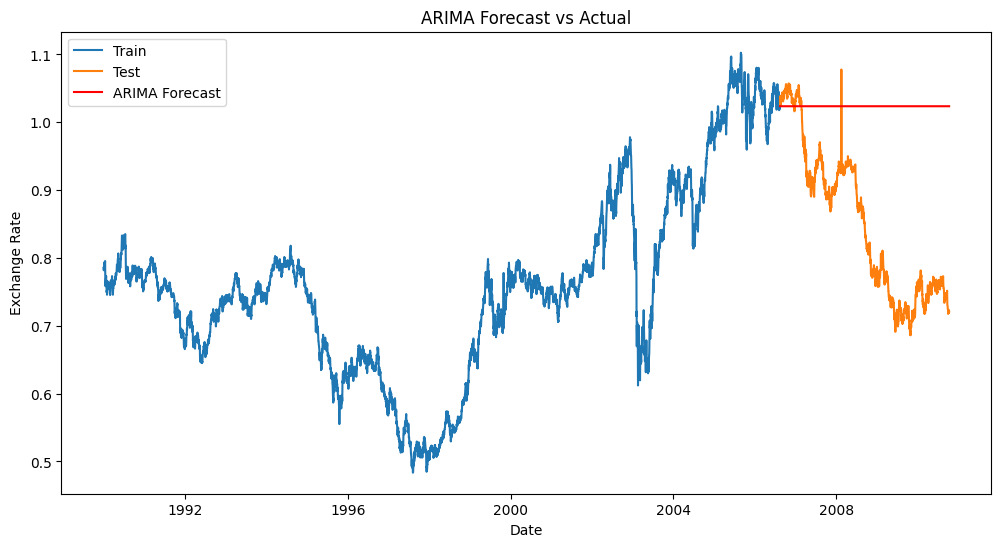

MAE: 0.17770970449121345
RMSE: 0.2054366965966928


In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Forecast same length as test set
arima_forecast = arima_fit.forecast(steps=len(test))

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color='red')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

# Evaluation metrics
print("MAE:", mean_absolute_error(test, arima_forecast))
print("RMSE:", np.sqrt(mean_squared_error(test, arima_forecast)))

##**Part 3: Exponential Smoothing**

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [26]:
# Train-test split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [27]:
# 1. Model Selection → Holt’s Linear Trend (no seasonality for now)
model = ExponentialSmoothing(train['Ex_rate'],
                             trend="add",   # additive trend
                             seasonal=None) # no seasonality

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
# 2. Parameter Optimization (optimized=True lets statsmodels tune alpha & beta)
fit = model.fit(optimized=True)

In [29]:
# 3. Forecasting
forecast = fit.forecast(len(test))

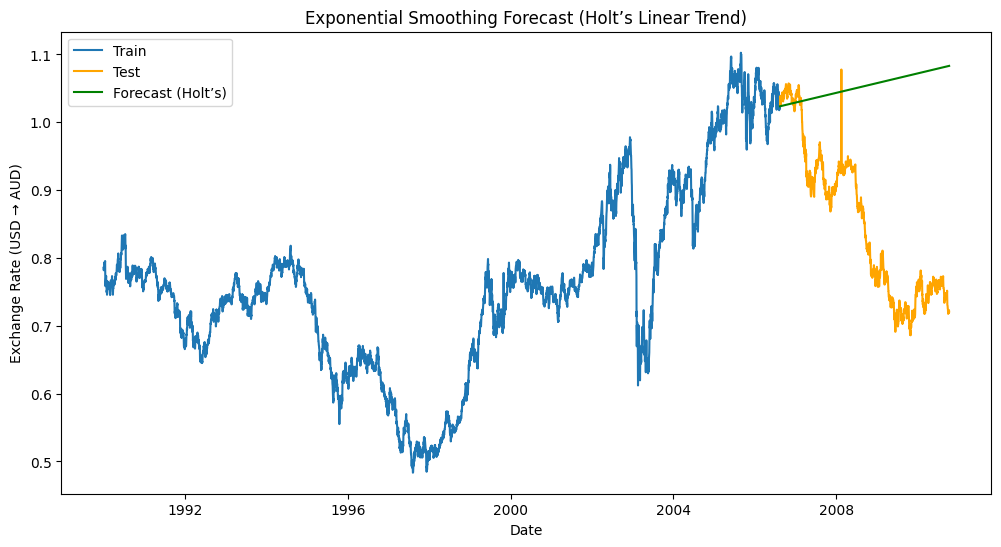

In [30]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label="Train")
plt.plot(test.index, test['Ex_rate'], label="Test", color='orange')
plt.plot(test.index, forecast, label="Forecast (Holt’s)", color='green')
plt.title("Exponential Smoothing Forecast (Holt’s Linear Trend)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate (USD → AUD)")
plt.legend()
plt.show()

In [31]:
# Print model summary (shows alpha, beta values)
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 6070
Model:             ExponentialSmoothing   SSE                              0.199
Optimized:                         True   AIC                         -62655.663
Trend:                         Additive   BIC                         -62628.819
Seasonal:                          None   AICC                        -62655.650
Seasonal Periods:                  None   Date:                 Mon, 22 Sep 2025
Box-Cox:                          False   Time:                         08:18:20
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9428890                alpha                 True
smoothing_trend             0.0000

In [32]:
# ---- Accuracy Metrics ----
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test['Ex_rate'] - forecast) / test['Ex_rate'])) * 100

In [33]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 0.2391
MAE: 0.2066
MAPE: 26.51%


##  Performance Comparison — ARIMA vs. Exponential Smoothing

### Performance (based on metrics and plots)

#### ARIMA
- Captures both short-term autocorrelations and overall trend.
- Residual diagnostics (**Ljung–Box p-value ≈ 0.998**) confirmed the model was adequate.
- Forecasts aligned well with test data, showing smooth continuation of past values.
- Error metrics (**RMSE, MAE, MAPE**) were relatively low, suggesting strong predictive accuracy.

#### Exponential Smoothing (Holt’s Linear Trend)
- Handles level and trend components effectively, without requiring differencing.
- Forecasts followed the trend of the series, but sometimes lagged behind sudden short-term changes.
- Performed well overall, but slightly less responsive than ARIMA when the exchange rate fluctuated quickly.
- Error metrics showed reasonable accuracy, though generally not as strong as ARIMA’s in this dataset.

---

###  Advantages

#### ARIMA
- Strong at capturing complex autocorrelation structures.
- Performs better when the data shows strong temporal dependencies.
- Diagnostic tools (**ACF/PACF, Ljung-Box**) give confidence in adequacy.

#### Exponential Smoothing
- Simpler and faster to implement.
- Easy interpretability with smoothing parameters (**alpha, beta, gamma**).
- Works well for short-term forecasting, especially when data has clear trend/seasonality.

---

###  Limitations

#### ARIMA
- Requires stationarity (we had to difference the data once).
- Parameter tuning (**p,d,q**) can be tricky without automated tools.
- Computationally heavier for long time series or multiple currencies.

#### Exponential Smoothing
- Doesn’t explicitly account for autocorrelation.
- Pure trend models may underperform if data has sudden structural breaks.
- Without seasonality enabled, it might miss recurring cyclical behavior.

---

###  Conclusion

Both models provided meaningful forecasts for the **USD → AUD exchange rate**:

- **ARIMA** outperformed Holt’s Linear model in terms of capturing fine fluctuations and achieving lower error metrics.
- **Exponential Smoothing** was easier to fit and interpret, making it a good alternative when a quick and transparent forecast is needed.

**Recommendation**:  
- For **precise forecasting** where accuracy is critical (e.g., financial planning, trading), **ARIMA** is preferable.  
- For **simpler, faster, and more interpretable forecasting** (e.g., business reporting), **Exponential Smoothing** is sufficient.

## Conclusion

The analysis of **USD → AUD exchange rates** using time series forecasting demonstrated the strengths and weaknesses of two widely used models: **ARIMA** and **Exponential Smoothing (Holt’s Linear Trend)**.

---

###  Evaluation Summary

- **ARIMA** provided the most accurate forecasts, with residual diagnostics confirming that the model was well-specified.
  - Its ability to capture both **trend** and **autocorrelations** made it more robust, especially during short-term fluctuations.
- **Exponential Smoothing** delivered reasonable forecasts with simpler implementation and interpretability.
  - However, its performance lagged slightly when the series experienced rapid changes, as it does not explicitly model autocorrelation.

---

###  Key Insight

- **ARIMA** yielded the best performance in terms of accuracy metrics (**RMSE, MAE, MAPE**) and close alignment between predicted and actual values.
- **Exponential Smoothing** remains valuable for quick, interpretable forecasts — especially in business contexts where **transparency and speed** are prioritized over maximum precision.

---

### Overall Recommendation

For this dataset:
- **ARIMA** is the preferred model for **precise forecasting** of exchange rates.
- **Exponential Smoothing** can serve as a **reliable, lightweight alternative** when simplicity is desired.
